# Chapter 9: Modeling Relationships
&copy; 2019 Kenneth Winston

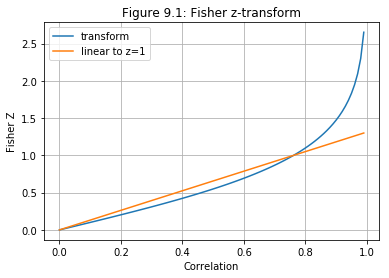

In [318]:
#Show Fisher z-transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def fisherz(rho):
    #Fisher z-transform
    return(.5*np.log((1+rho)/(1-rho)))

x=np.arange(.0001,.9999,.01)
plt.plot(x,fisherz(x),label="transform")

fzeq1=(np.exp(2)-1)/(np.exp(2)+1)  #argument where z-transform equals one
plt.plot(x,x/fzeq1,label="linear to z=1")
plt.title("Figure 9.1: Fisher z-transform")
plt.xlabel("Correlation")
plt.ylabel("Fisher Z")
plt.legend()
plt.grid()
plt.show();

In [319]:
#Acquire log-return data
#Intrinio only returns 100 data points per request
#(you can ask for more once or twice, but it will quickly tell you that you are asking for too much)
#So you have to iterate requests if you want more than 100 data points; that's taken care in this code segment

import intrinio_sdk
from intrinio_sdk.rest import ApiException
from dateutil import parser
import numpy as np
import pandas as pd
import qrbook_funcs as qf

#Give access information
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = #Insert your intrinio API key here
security_api = intrinio_sdk.SecurityApi()

#List of period-end dates
date_list=[]; need_dates = True

tickerlist=['ORCL','ED','C']
start_date='1997-12-31'
sd_dateform=parser.parse(start_date).date()   #format compatible with Intrinio
end_date=qf.LastYearEnd()[:4]+'-12-31' #Intrinio uses 12-31 even if it's not a business day
frequency = 'monthly'

for identifier in tickerlist:
    print('Inputting ',identifier)
    next_page = None
    date_offset = 0
    try:
        while True:  #loop through pages - only get 100 data points at a time
            if next_page is None:    #Intrinio can't take a next_page=None argument
                #First call to get_security_stock_prices
                api_response = security_api.get_security_stock_prices(identifier, \
                    start_date=start_date, end_date=end_date, \
                    frequency=frequency)
                lr_list=[]
                if need_dates:    #First security?
                    date_list=[]
                new_obs=api_response.stock_prices[0].adj_close    #prime the new_obs pump
            else:
                #There was a previous call to get_security_stock_prices
                api_response = security_api.get_security_stock_prices(identifier, \
                    start_date=start_date, end_date=end_date, \
                    frequency=frequency, next_page = next_page)
                #compute log-return that spans two calls of get_security_stock_prices
                old_obs=api_response.stock_prices[0].adj_close
                lr_list.append(np.log(new_obs/old_obs))
                new_obs=old_obs
            #transfer to list
            num_obs=len(api_response.stock_prices)
            next_next_page = api_response.next_page    #used to see if we are on the last iteration
            for i in range(num_obs):
                if (next_next_page is None) and (i==num_obs-1):   #last iteration, don't record last date
                    break    #for i
                this_date=api_response.stock_prices[i].date
                if need_dates:
                    date_list.append(this_date)
                else:
                    if this_date != date_list[i+date_offset]:
                        print('Date disagreement',identifier,date_list[i+date_offset],this_date)
                        exit()
                if i < num_obs-1:
                    old_obs=api_response.stock_prices[i+1].adj_close
                    lr_list.append(np.log(new_obs/old_obs))
                    new_obs=old_obs

            date_offset += num_obs
            next_page = next_next_page
            if next_page is None:
                break     #while
                
    except ApiException as e:
        print("Exception when calling SecurityApi->get_security_historical_data: %s\n" % e)
    #end try - this security now acquired
    #transfer to dataframe
    
    if need_dates:
        need_dates = False
        #reverse order so oldest is first
        df_logs = pd.DataFrame({'Date':date_list[::-1]})

    df_logs[identifier] = lr_list[::-1]  #reverse order to agree with dates
    #end for loop
    
#df_logs is a dataframe that has month-end dates (df_logs['Date']) and
#log-returns of the tickers in tickerlist, e.g. df_logs['AAPL']

print("Data acquired.",len(tickerlist),' tickers, ',len(df_logs),' observations.')

Inputting  ORCL
Inputting  ED
Inputting  C
Data acquired. 3  tickers,  252  observations.


In [320]:
#Get and show correlation matrix and
#standard deviations
nobs=len(df_logs)
corr_matrix=df_logs.corr()
cov_matrix=df_logs.cov()
std_devs=[]
for i in range(len(tickerlist)):
    std_devs.append(np.sqrt(12*cov_matrix.iloc[i,i]))
    
print("Correlation Matrix and standard deviations (9.10):")
print(corr_matrix)
print('Annualized standard deviations:\n',std_devs)
zsig=np.sqrt(1/(nobs-3))
rsig=(np.exp(2*zsig)-1)/(np.exp(2*zsig)+1)
print('Correlation significance:',rsig)

Correlation Matrix and standard deviations (9.10):
          ORCL        ED         C
ORCL  1.000000 -0.105194  0.258718
ED   -0.105194  1.000000  0.008589
C     0.258718  0.008589  1.000000
Annualized standard deviations:
 [0.39512382043455685, 0.16449584149119104, 0.44348057273025215]
Correlation significance: 0.06328772520348246


In [321]:
#Compute minimum variance portfolio of ORCL/ED/F (4.17)
cov_matrix_inverse=pd.DataFrame(np.linalg.pinv(cov_matrix.values), \
            cov_matrix.columns,cov_matrix.index)
u=pd.Series([1]*len(cov_matrix_inverse),index=cov_matrix_inverse.index)
minvport=cov_matrix_inverse.dot(u)
minvar=1/minvport.dot(u)  #This is second part of formula (4.17)
minvport*=minvar    #This is first part of formula (4.17)
print('Minimum variance portfolio:\n',minvport)

#Annualized standard deviation
annminstd=np.sqrt(minvar*12)
print('Minimum annualized std deviation:',annminstd)

Minimum variance portfolio:
 ORCL    0.145237
ED      0.787270
C       0.067493
dtype: float64
Minimum annualized std deviation: 0.14266011045911423


Cholesky:
 [[ 1.          0.          0.        ]
 [-0.10519415  0.9944517   0.        ]
 [ 0.25871836  0.03600476  0.96528155]]


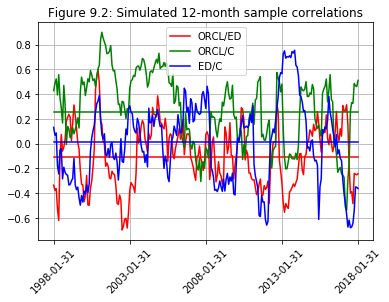

In [322]:
#Generate graph of either simulated or historical sample correlations
#from df_logs

def make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate):
#Generate a multivariate normal distribution using the data in df_logs
#compute sample correlations of size samplesize and graph them
#simulate: False, use historical data in df_logs
#          True, use simulated data in rtrial
    nobs=len(df_logs)
    nsecs=len(df_logs.columns)-1
    samplecorrs=[]
    corr_matrix=df_logs.corr()

    #Get sample correlations
    if simulate:
        for i in range(samplesize,nobs+1):
            samplecorrs.append(np.corrcoef(rtrial[i-samplesize:i].transpose()))
    else:
        for i in range(samplesize,nobs+1):
            samplecorrs.append(df_logs.sort_values(by="Date").iloc[i-samplesize:i].corr().values)
        
    #plot sample correlations
    sccol=['r','g','b']
    ncorrs=nsecs*(nsecs-1)/2
    z=0
    #Go through each pair
    for j in range(nsecs-1):
        for k in range(j+1,nsecs):
            #form time series of sample correlation
            #for this pair of securities
            scs=[samplecorrs[i][j,k] for i in range(nobs-samplesize+1)]
            plt.plot(range(nobs-samplesize+1),scs, \
                     label=corr_matrix.columns[j]+'/' \
                     +corr_matrix.columns[k], \
                     color=sccol[z])
            #Show target correlation in same color
            line=[corr_matrix.iloc[j,k]]*(nobs-samplesize+1)
            plt.plot(range(nobs-samplesize+1),line,color=sccol[z])
            z+=1

    plt.legend()
    stride=int((nobs-12+1)/(48))*12
    plt.xticks(range(0,nobs-samplesize+1,stride),df_logs.sort_values(by="Date")["Date"][0:nobs-samplesize+1:stride],rotation=45)
    plt.title(title_str+str(samplesize)+'-month sample correlations')
    plt.grid()
    plt.show();


#Generate a simulation    
#Show the Cholesky decomposition of the matrix
chol=np.linalg.cholesky(corr_matrix)
print('Cholesky:\n',chol)

#Generate random draws
nobs=len(df_logs)
nsecs=len(df_logs.columns)-1
strial=np.random.normal(0,1,size=[nobs,nsecs])
rtrial=np.matmul(chol,strial.T).T

samplesize=12
title_str="Figure 9.2: Simulated "
simulate=True
make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate)

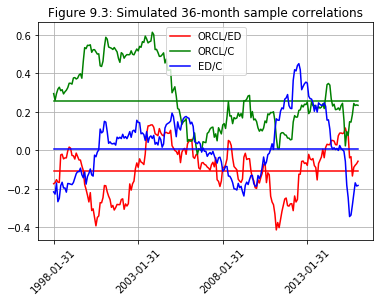

In [323]:
#Get sample 36-month correlations
samplesize=36
title_str="Figure 9.3: Simulated "
simulate=True
make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate)

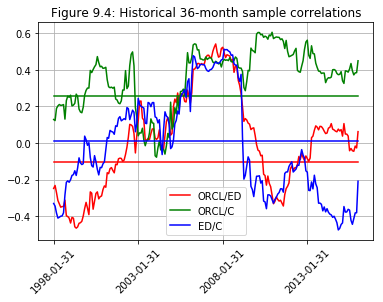

In [324]:
#Get sample 36-month correlations
samplesize=36
title_str="Figure 9.4: Historical "
simulate=False
make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate)

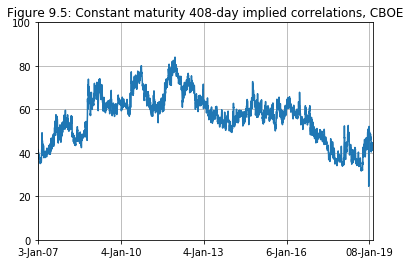

In [325]:
from datetime import date
from datetime import timedelta
#Read in CBOE implied correlation series and form
#constant-maturity series

url='http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/implied_correlation_hist.csv'

dfic=pd.read_csv(url,skiprows=1)

#Form option expiration dates; close enough
#to guess the 19th of January
expiries=[]
for i in range(3,len(dfic.columns)):
    expiries.append(date(int(dfic.columns[i][-4:]),1,19))
    
#In 2019 appears to be a misprint - last column should be 2021, not 2020
if expiries[-1]==expiries[-2]:
    expiries[-1]=date(expiries[-1].year+1,expiries[-1].month,expiries[-1].day)

#Interpolate current column and next column
offset=408   #New series are created around 408 days to expiration
             #offset gives max weight to new series at 408 days
currcol=3
interpcorr=[]
for i in range(len(dfic)):
    currdate=parser.parse(dfic.DATE[i]).date()
    #Is everything blank?
    if pd.DataFrame.all(pd.isna(dfic.iloc[i,3:])):
        ic=dfic.iloc[i,currcol]  #Leave value blank
    else:
        #Do we need to move to the next series?
        if pd.isna(dfic.iloc[i,currcol]):
            currcol+=1
        #Get bracketing correlations
        try:
            corr1=np.float64(dfic.iloc[i,currcol])
        except ValueError:
            corr1=0
        try:
            corr2=np.float64(dfic.iloc[i,currcol+1])
        except ValueError:
            corr2=0
        #Blank data?
        if corr2==0:
            ic=corr1
        elif corr1==0:
            ic=corr2
        else:
            #Figure weights based on how far from ideal (offset) days
            days1=expiries[currcol-3]-currdate
            days1=np.abs(days1.days-offset)
            days2=expiries[currcol-2]-currdate
            days2=np.abs(days2.days-offset)
            ic=days1*corr2+days2*corr1
            ic/=(days1+days2)
    interpcorr.append(ic)

#Appears to be a bad data point at 3-Mar-10. Also, interpolate where there are nans
badlist=[dfic.loc[dfic['DATE']=='3-Mar-10'].index[0]]+[x[0] for x in np.argwhere(np.isnan(interpcorr))]
#Interpolate around points on the badlist
for badindex in badlist:
    interpcorr[badindex]=(interpcorr[badindex-1]+interpcorr[badindex+1])/2

#interpcorr now has interpolated correlations; plot them
plt.plot(range(len(interpcorr)),interpcorr)
plt.grid()
plt.title('Figure 9.5: Constant maturity '+str(offset)+'-day implied correlations, CBOE')
icdates=dfic.DATE
nobs=len(icdates)
stride=int(nobs/48)*12
plt.xticks(range(0,nobs+stride,stride),icdates[0:nobs+stride:stride])
plt.xlim(0,nobs)
plt.ylim(0,100)
plt.show()

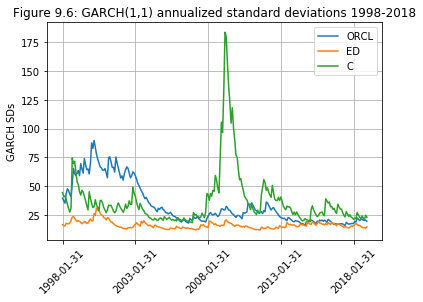

ORCL a=0.1188 b=0.8626 c=0.00011996 AnnEquilibStd=0.2786
ED a=0.1138 b=0.8001 c=0.00018801 AnnEquilibStd=0.1619
C a=0.2359 b=0.7193 c=0.00065883 AnnEquilibStd=0.4198


In [326]:
import scipy.stats as spst
from scipy.optimize import minimize_scalar

#CHEAT! - get overall mean and standard deviation vectors
#In practice, would need to do everything out of sample - start with a learning sample, e.g.
overallmean=np.mean(df_logs)
overallstd=np.std(df_logs)

#Get GARCH params for each ticker
gparams=[]
initparams=[.12,.85,.6]
stgs=[] #Save the running garch sigma's
for it,ticker in enumerate(tickerlist):
    #Note ORDER MATTERS: make sure values are in date order
    gparams.append(qf.Garch11Fit(initparams,df_logs.sort_values(by="Date")[ticker]))
    a,b,c=gparams[it]
    
    #Create time series of sigmas
    t=len(df_logs[ticker])
    minimal=10**(-20)
    stdgarch=np.zeros(t)
    stdgarch[0]=overallstd[ticker]
    #Compute GARCH(1,1) stddev's from data given parameters
    for i in range(1,t):
        #Note offset - i-1 observation of data
        #is used for i estimate of std deviation
        previous=stdgarch[i-1]**2
        var=c+b*previous+\
            a*(df_logs.sort_values(by="Date")[ticker][i-1]-overallmean[ticker])**2
        stdgarch[i]=np.sqrt(var)

    #Save for later de-GARCHing
    stgs.append(stdgarch)
    
#Create plot
for it,ticker in enumerate(tickerlist):
    #Annualize
    stdgarch=100*np.sqrt(12)*stgs[it]
    plt.plot(range(len(stdgarch)),stdgarch,label=ticker)

plt.grid()
plt.title('Figure 9.6: GARCH(1,1) annualized standard deviations '+ \
          str(min(df_logs["Date"]).year)+'-'+str(max(df_logs["Date"]).year))
plt.ylabel('GARCH SDs')
plt.legend()
stride=60
plt.xticks(range(0,len(df_logs),stride),df_logs.sort_values(by="Date")["Date"][0:len(df_logs)-1:stride],rotation=45)
plt.show()

for it,tick in enumerate(tickerlist):
    print(tick,'a=%1.4f' % gparams[it][0], \
               'b=%1.4f' % gparams[it][1], \
               'c=%1.8f' % gparams[it][2], \
               'AnnEquilibStd=%1.4f' % \
               np.sqrt(12*gparams[it][2]/(1-gparams[it][0]-gparams[it][1])))

In [327]:
#Display before and after statistics
for it,ticker in enumerate(tickerlist):
    print(ticker)
    print('    Raw monthly Std Dev:',overallstd[ticker])
    print('    Raw annualized Std Dev:',np.sqrt(12)*overallstd[ticker])
    print('    Raw excess kurtosis:',spst.kurtosis(df_logs[ticker]))

#Demeaned, DeGARCHed series go in dfeps
dfeps=df_logs.sort_values(by="Date")[tickerlist].copy()
dfeps=dfeps-overallmean
for it,ticker in enumerate(tickerlist):
    for i in range(len(dfeps)):
        dfeps[ticker].iloc[i]/=stgs[it][i]
    print(ticker)
    print('    DeGARCHed Mean:',np.mean(dfeps[ticker]))
    print('    DeGARCHed Std Dev:',np.std(dfeps[ticker]))
    print('    DeGARCHed Excess Kurtosis:',spst.kurtosis(dfeps[ticker]))

ORCL
    Raw monthly Std Dev: 0.1138358827513424
    Raw annualized Std Dev: 0.39433906529955726
    Raw excess kurtosis: 3.689365272570827
ED
    Raw monthly Std Dev: 0.04739154755205673
    Raw annualized Std Dev: 0.16416913641895742
    Raw excess kurtosis: 0.6762335672014315
C
    Raw monthly Std Dev: 0.1277675499905242
    Raw annualized Std Dev: 0.44259977628436864
    Raw excess kurtosis: 11.593201066693771
ORCL
    DeGARCHed Mean: -0.026090741618431307
    DeGARCHed Std Dev: 1.010740795498199
    DeGARCHed Excess Kurtosis: -0.07645334962631889
ED
    DeGARCHed Mean: 0.0010706622375457238
    DeGARCHed Std Dev: 1.0039611337283445
    DeGARCHed Excess Kurtosis: 0.04862823222459234
C
    DeGARCHed Mean: 0.029402682821840425
    DeGARCHed Std Dev: 1.0039947597882661
    DeGARCHed Excess Kurtosis: 2.0571586363219287


Optimal lambda: 0.0191710841396228
Optimal objective function: 733.290602158207
Half-life (months): 35.80817593350826


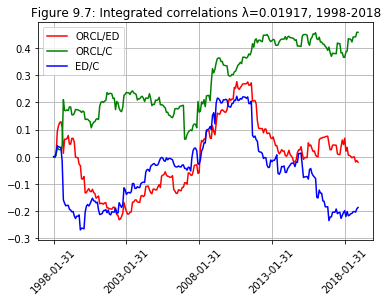

In [328]:
#Compute integrated correlations

InData=np.array(dfeps)

def IntegratedCorrObj(s):
    #Compute time series of quasi-correlation
    #matrices from InData using integrated parameter
    #xlam=exp(s)/(1+exp(s)); note this format removes
    #the need to enforce bounds of xlam being between
    #0 and 1. This is applied to formula 9.34.
    #Standardize Q's and apply formula 9.39.
    #Returns scalar 9.39
    xlam=np.exp(s)
    xlam/=1+xlam
    obj9p39=0.
    previousq=np.identity(len(InData[0]))
    #Form new shock matrix
    for i in range(len(InData)):
        #standardize previous q matrix
        #and compute contribution to objective
        #function
        stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
        previousr=np.matmul(stdmtrx,np.matmul(previousq,stdmtrx))
        #objective function
        obj9p39+=np.log(np.linalg.det(previousr))
        shockvec=np.array(InData[i])
        vec1=np.matmul(shockvec,np.linalg.inv(previousr))
        #This makes obj9p39 into a 1,1 matrix
        obj9p39+=np.matmul(vec1,shockvec)
              
        #Update q matrix
        shockvec=np.mat(shockvec)
        shockmat=np.matmul(shockvec.T,shockvec)
        previousq=xlam*shockmat+(1-xlam)*previousq
    return(obj9p39[0,0])
#Done with IntegratedCorrObj

result=minimize_scalar(IntegratedCorrObj)

xlamopt=np.exp(result.x)
xlamopt/=1+xlamopt
print('Optimal lambda:',xlamopt)
print('Optimal objective function:', \
      result.fun)
if xlamopt>=1 or xlamopt==0:
    halflife=0
else:
    halflife=-np.log(2)/np.log(1-xlamopt)
print('Half-life (months):',halflife)

#Plot integrated correlations
previousq=np.identity(len(InData[0]))
rmatrices=[]
for i in range(len(InData)):
    stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
    rmatrices.append(np.matmul(stdmtrx,np.matmul(previousq,stdmtrx)))
    shockvec=np.mat(np.array(InData[i]))
    #Update q matrix
    shockmat=np.matmul(shockvec.T,shockvec)
    previousq=xlamopt*shockmat+(1-xlamopt)*previousq

iccol=['r','g','b']
z=0
for it in range(len(tickerlist)-1):
    for jt in range(it+1,len(tickerlist)):
        y=[rmatrices[i][it,jt] for i in range(len(InData))]
        plt.plot(range(len(InData)),y, \
            label=tickerlist[it]+'/'+tickerlist[jt], \
            color=iccol[z])
        z+=1
plt.grid()
xtitle='Figure 9.7: Integrated correlations λ=%1.5f' % xlamopt
xtitle+=', '+str(min(df_logs["Date"]).year)+'-'+str(max(df_logs["Date"]).year)
plt.title(xtitle)
stride=60
plt.xticks(range(0,len(df_logs),stride),df_logs.sort_values(by="Date")["Date"][0:len(df_logs)-1:stride],rotation=45)
plt.legend()
plt.show()

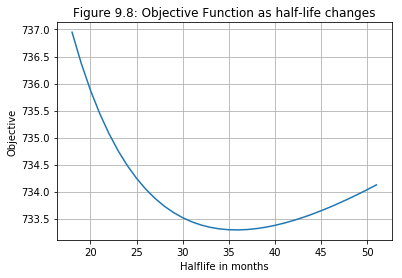

In [329]:
#Map of objective with respect to half-life
halflife=int(halflife)
delta_halflife=int(halflife/2)
y=[]
for h in range(halflife-delta_halflife,halflife+delta_halflife):
    xlam=1-(.5)**(1/h)
    s=np.log(xlam/(1-xlam))    
    y.append(IntegratedCorrObj(s))
    
plt.plot(range(halflife-delta_halflife,halflife+delta_halflife),y)
plt.title("Figure 9.8: Objective Function as half-life changes")
plt.xlabel("Halflife in months")
plt.ylabel("Objective")
plt.grid()
plt.show();

C:\Users\kenwi\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Optimal alpha, beta: 0.029196165404162394 0.892109118963283
Optimal objective function: 721.9125799670844
Half-life (months): 23.392749746760817


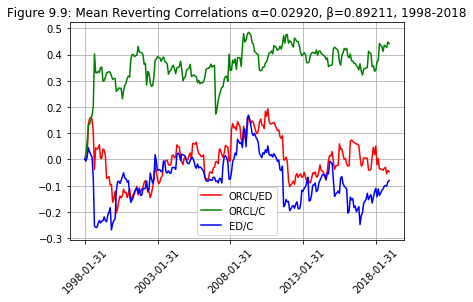

In [330]:
def MeanRevCorrObj(params):
    #Compute time series of quasi-correlation
    #matrices from InData using mean reverting
    #formula 9.35. Standardize them and apply
    #formula 9.39. Returns scalar 9.39
    
    #Extract parameters
    alpha,beta=params
    #Enforce bounds
    if alpha<0 or beta<0:
        return(10**20)
    elif (alpha+beta)>.999:
        return(10**20)
    obj9p39=0
    #Initial omega is obtained through correlation targeting
    Rlong=np.corrcoef(InData.T)
    previousq=np.identity(len(InData[0]))
    #Form new shock matrix
    for i in range(len(InData)):
        #standardize previous q matrix
        #and compute contribution to objective
        #function
        stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
        previousr=np.matmul(stdmtrx,np.matmul(previousq,stdmtrx))
        #objective function
        obj9p39+=np.log(np.linalg.det(previousr))
        shockvec=np.array(InData[i])
        vec1=np.matmul(shockvec,np.linalg.inv(previousr))
        #This makes obj9p39 into a 1,1 matrix
        obj9p39+=np.matmul(vec1,shockvec)
              
        #Update q matrix
        shockvec=np.mat(shockvec)
        shockmat=np.matmul(shockvec.T,shockvec)
        previousq=(1-alpha-beta)*Rlong+alpha*shockmat+beta*previousq
    return(obj9p39[0,0])
#Done with MeanRevCorrObj

import scipy.optimize as scpo
#alpha and beta positive
corr_bounds = scpo.Bounds([0,0],[np.inf,np.inf])
#Sum of alpha and beta is less than 1
corr_linear_constraint = \
    scpo.LinearConstraint([[1, 1]],[0],[.999])

initparams=[.02,.93]

results = scpo.minimize(MeanRevCorrObj, \
        initparams, \
        method='trust-constr', \
        jac='2-point', \
        hess=scpo.SR1(), \
        bounds=corr_bounds, \
        constraints=corr_linear_constraint)

alpha,beta=results.x
print('Optimal alpha, beta:',alpha,beta)
print('Optimal objective function:',results.fun)
halflife=-np.log(2)/np.log(1-alpha)
print('Half-life (months):',halflife)

#Plot mean reverting correlations
previousq=np.identity(len(InData[0]))
Rlong=np.corrcoef(InData.T)
rmatrices=[]
for i in range(len(InData)):
    stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
    rmatrices.append(np.matmul(stdmtrx,np.matmul(previousq,stdmtrx)))
    shockvec=np.mat(np.array(InData[i]))
    #Update q matrix
    shockmat=np.matmul(shockvec.T,shockvec)
    previousq=(1-alpha-beta)*Rlong+alpha*shockmat+beta*previousq

iccol=['r','g','b']
z=0
for it in range(len(tickerlist)-1):
    for jt in range(it+1,len(tickerlist)):
        y=[rmatrices[i][it,jt] for i in range(len(InData))]
        plt.plot(range(len(dfeps)),y, \
            label=tickerlist[it]+'/'+tickerlist[jt], \
            color=iccol[z])
        z+=1
plt.grid()
xtitle='Figure 9.9: Mean Reverting Correlations α=%1.5f' % alpha
xtitle+=', β=%1.5f' % beta
xtitle+=', '+str(min(df_logs["Date"]).year)+'-'+str(max(df_logs["Date"]).year)
plt.title(xtitle)
stride=60
plt.xticks(range(0,len(df_logs),stride),df_logs.sort_values(by="Date")["Date"][0:len(df_logs)-1:stride],rotation=45)
plt.legend()
plt.show();

In [331]:
#MacGyver method - pairwise integrated
minimal=10**(-20)
xlams=[]
for it in range(len(tickerlist)-1):
    tick1=tickerlist[it]
    for jt in range(it+1,len(tickerlist)):
        tick2=tickerlist[jt]
        InData=np.array(dfeps[[tick1,tick2]])
        result=minimize_scalar(IntegratedCorrObj)
        xlamopt=np.exp(result.x)/(1+np.exp(result.x))
        print(tick1,tick2)
        print('    Optimal lambda:',xlamopt)
        print('    Optimal objective function:', \
              result.fun)
        if np.absolute(xlamopt)<minimal or xlamopt>=1:
            halflife=0
        else:
            halflife=-np.log(2)/np.log(1-xlamopt)
        print('    Half-life (months):',halflife)
        xlams.append(xlamopt)

print('\nMedian MacGyver lambda:',np.median(xlams))

ORCL ED
    Optimal lambda: 1.333223459588212e-32
    Optimal objective function: 511.6146302829898
    Half-life (months): 0
ORCL C
    Optimal lambda: 0.021010821008751335
    Optimal objective function: 476.64410498936513
    Half-life (months): 32.64220915900315
ED C
    Optimal lambda: 0.03712176487443477
    Optimal objective function: 509.3166556221824
    Half-life (months): 18.323499665941718

Median MacGyver lambda: 0.021010821008751335
